# Reservoir Computing: Theory and Basics

Reservoir computing is a computational framework for training recurrent neural networks efficiently. It separates the dynamic processing of inputs (handled by a fixed recurrent network — the "reservoir") from the learning mechanism (handled by a simple linear readout layer).

## 📌 Learning Objectives
- Understand the concept of reservoir computing and Echo State Networks (ESNs)
- Learn the core equations and assumptions
- Implement a simple ESN for a sine wave prediction task

## 🔁 1. Motivation: Recurrent Neural Networks (RNNs)

RNNs are powerful models for temporal and sequential data but are notoriously difficult to train because of:
- **Vanishing/exploding gradients**
- **High computational cost**
- **Instability with long sequences**

Reservoir computing offers a way to leverage the dynamic power of RNNs while avoiding backpropagation through time.


## 🌊 2. Echo State Networks (ESNs)

An ESN consists of:
- **Input weights** \( \mathbf{W}_{in} \)
- **Reservoir (recurrent) weights** \( \mathbf{W}_{res} \)
- **Readout weights** \( \mathbf{W}_{out} \)

### State Update Equation
$$
\mathbf{x}(t+1) = \tanh(\mathbf{W}_{res} \mathbf{x}(t) + \mathbf{W}_{in} \mathbf{u}(t))
$$

### Output Equation
$$
\mathbf{y}(t) = \mathbf{W}_{out} \mathbf{x}(t)
$$

> Note: Only $\mathbf{W}_{out}$ is trained using ridge regression or linear regression.


In [2]:
# 📦 3. Import Libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

In [ ]:
# 🧠 4. Reservoir Initialization
def generate_reservoir(N, sparsity=0.1, spectral_radius=0.9):
    W = np.random.randn(N, N)
    mask = np.random.rand(N, N) < sparsity
    W *= mask
    eigvals = np.linalg.eigvals(W)
    W *= spectral_radius / np.max(np.abs(eigvals))
    return W

In [ ]:
# 🔧 5. Create Echo State Network (ESN)
class ESN:
    def __init__(self, n_input, n_reservoir, n_output, spectral_radius=0.9, sparsity=0.1, ridge_alpha=1e-6):
        self.n_reservoir = n_reservoir
        self.Win = np.random.uniform(-1, 1, (n_reservoir, n_input))
        self.Wres = generate_reservoir(n_reservoir, sparsity, spectral_radius)
        self.Wout = None
        self.ridge_alpha = ridge_alpha
        self.state = np.zeros(n_reservoir)

    def _update(self, u):
        self.state = np.tanh(self.Wres @ self.state + self.Win @ u)
        return self.state

    def fit(self, U, Y):
        states = np.vstack([self._update(u) for u in U])
        reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        reg.fit(states, Y)
        self.Wout = reg.coef_

    def predict(self, U):
        preds = []
        for u in U:
            x = self._update(u)
            y = self.Wout @ x
            preds.append(y)
        return np.array(preds)

# 📈 6. Example: Predicting a Sine Wave

In [ ]:
timesteps = 500
t = np.linspace(0, 20 * np.pi, timesteps)
signal = np.sin(t).reshape(-1, 1)

train_len = 300
test_len = 200

train_input = signal[:train_len]
test_input = signal[train_len-1:-1]
train_output = signal[1:train_len+1]
test_output = signal[train_len:]

In [ ]:
# 🧪 7. Train and Test the ESN
esn = ESN(n_input=1, n_reservoir=100, n_output=1, spectral_radius=0.95)
esn.fit(train_input, train_output)
predicted = esn.predict(test_input)

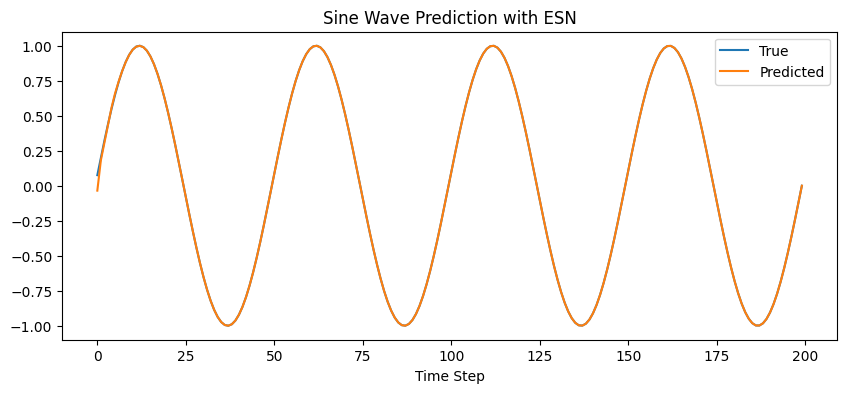

In [8]:
# 📊 8. Visualize Results
plt.figure(figsize=(10, 4))
plt.plot(range(test_len), test_output, label="True")
plt.plot(range(test_len), predicted, label="Predicted")
plt.title("Sine Wave Prediction with ESN")
plt.xlabel("Time Step")
plt.legend()
plt.show()

## ✅ 9. Summary

- ESNs simplify RNN training by keeping the reservoir fixed and only learning the output weights
- Spectral radius is key to controlling reservoir dynamics (Echo State Property)
- This example showed a simple application to time series prediction

## 📚 References
- H. Jaeger (2001). *The "Echo State" Approach to Analyzing and Training Recurrent Neural Networks*.
- M. Lukosevicius and H. Jaeger (2009). *Reservoir computing approaches to recurrent neural network training*.

> Want to explore more? Try:
- Mackey-Glass series prediction
- Lorenz attractor reconstruction
- Spoken digit classification with ESNs
